In [6]:
import sagemaker
from sagemaker.transformer import Transformer
from sagemaker.xgboost import XGBoostModel
from sagemaker import get_execution_role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


SETTINGS

In [4]:
# Specify the S3 path where the trained model is stored
model_data = 's3://sagemaker-eu-west-1-211125740051/xgboost-05-2024-07-01-10-55-25-128/output/model.tar.gz' # This path can be retreived from training job

DELETE THE OUTPUT

In [3]:
!aws s3 rm s3://sagemaker-bucket-ds/training-jobs/data/inference_output/ --recursive

CREATE BASIC OBJECTS

In [7]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()

LOAD XGBOOST MODEL FROM S3

In [8]:
# Create the XGBoost model using the default serving container
xgboost_model = XGBoostModel(
    model_data=model_data,
    role=role,
    framework_version='1.3-1',
    sagemaker_session=sagemaker.Session()
)

CREATE TRANSFORMER

In [9]:
# Create the transformer object for batch transform
transformer = xgboost_model.transformer(
    instance_count=1,
    instance_type='ml.m5.large',
    output_path='s3://sagemaker-bucket-ds/training-jobs/data/inference_output/' # The path where the results will be saved
)

In [10]:
# Start the batch transform job
transformer.transform(
    data='s3://sagemaker-bucket-ds/training-jobs/data/inference_input/', # Path where the input is stored
    content_type='text/csv', # It is neccessary because csv is not default format
    split_type='Line' # Each line equals one observation
)

# Wait for the transform job to complete
transformer.wait()

INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-07-01-11-49-10-490


............................[2024-07-01:11:53:50:INFO] No GPUs detected (normal if no gpus installed)
[2024-07-01:11:53:50:INFO] No GPUs detected (normal if no gpus installed)
[2024-07-01:11:53:50:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-07-01 11:53:51 +0000] [16] [INFO] Starting gunicor

The batch transform job is processing
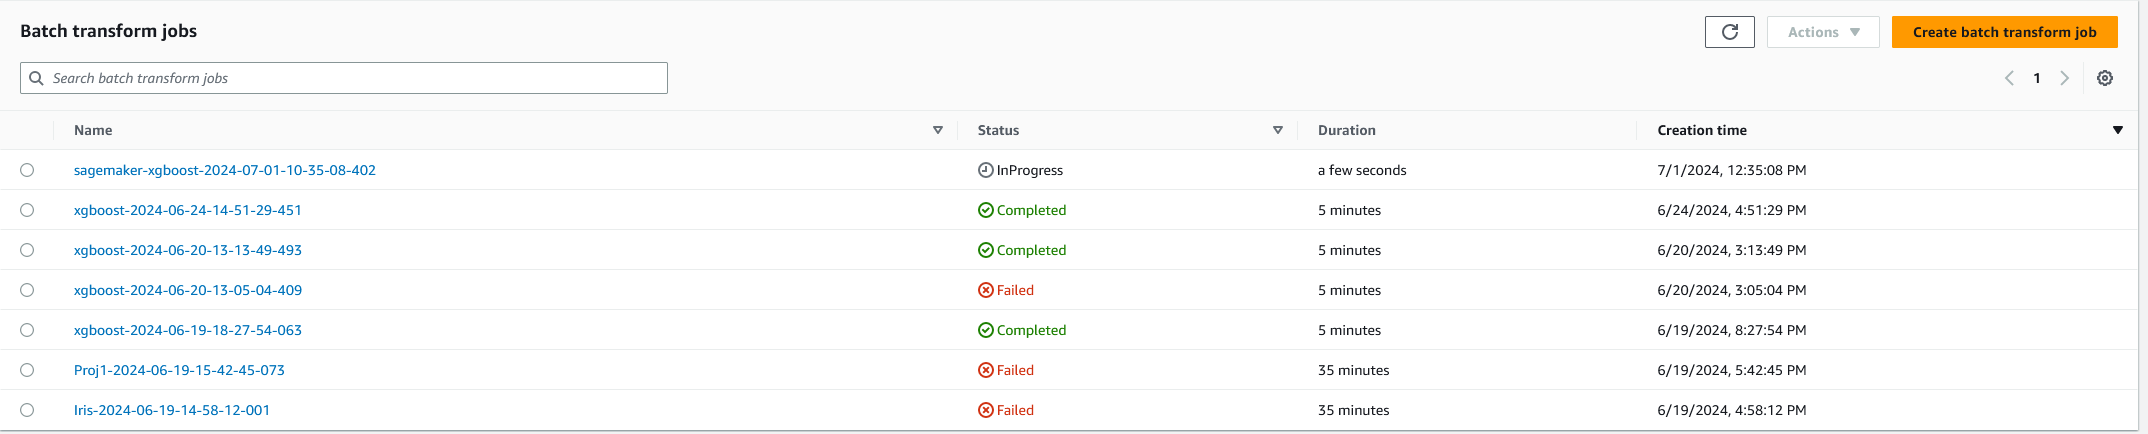